In [1]:
import numpy as np
from collections import Counter
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt


RANDOM_STATE = 0
tf.random.set_seed(RANDOM_STATE)

2024-05-09 19:29:14.622184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 19:29:14.624245: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 19:29:14.724383: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 19:29:15.081225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 19:29:16.320825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

### Data load, explore and preprocess
1. shape and size view
2. nan data check
3. class similarity

Train size: 18928
Test size: 4732
Image shape: (28, 28)

Nan value exists detect
X_train: False
y_train: False
X_test: False
y_test: False

num of class: Counter({6: 4201, 10: 2196, 0: 1741, 9: 1682, 5: 1651, 4: 1562, 8: 1546, 7: 1519, 3: 978, 1: 936, 2: 916})


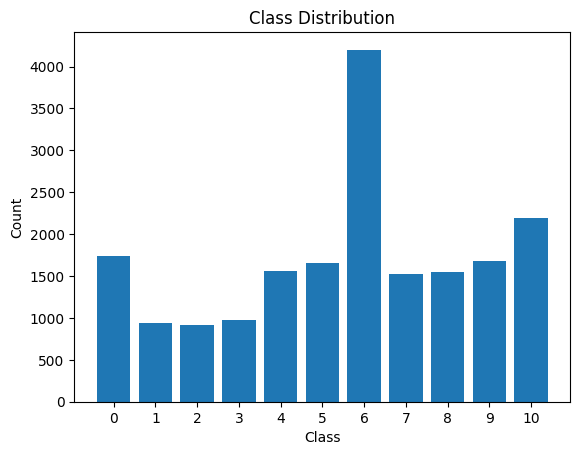

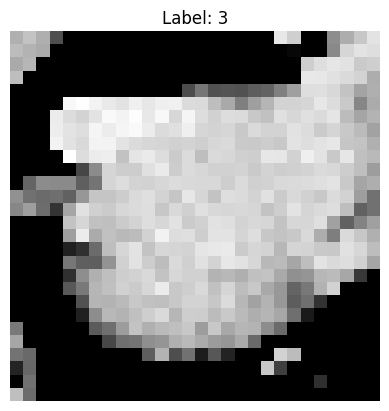

In [2]:
# loading
X_train = np.load('dataset/Assignment2Data/X_train.npy')
X_test = np.load('dataset/Assignment2Data/X_test.npy')
y_train = np.load('dataset/Assignment2Data/y_train.npy')
y_test = np.load('dataset/Assignment2Data/y_test.npy')

# data size and shape
print(f"Train size: {X_train.shape[0]}\nTest size: {X_test.shape[0]}\nImage shape: {X_test.shape[1:]}\n")

# Check nan values
def check_nan(data) -> bool:
    return np.isnan(data).any()

print(f"Nan value exists detect\nX_train: {check_nan(X_train)}\ny_train: {check_nan(y_train)}\nX_test: {check_nan(X_test)}\ny_test: {check_nan(y_test)}\n")

# num of class
cnt_class = Counter(y_train)
print(f"num of class: {cnt_class}")
classes = list(cnt_class.keys())
counts = list(cnt_class.values())

# visual of class
plt.bar(classes, counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(classes)
plt.show()

# single image show
image_index = 3
image = X_train[image_index]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {y_train[image_index]}")
plt.axis('off')
plt.show()



In [3]:
'''
Preprocess
1. label one-hot encode (for FNN and CNN)
2. train-valid split and data reshape (for FNN and CNN)
'''

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
X_train_re = X_train.reshape(-1, 28, 28, 1)
X_val_re = X_val.reshape(-1, 28, 28, 1)
X_test_re = X_test.reshape(-1, 28, 28, 1)

y_train_encoded = to_categorical(y_train, 11)
y_val_encoded = to_categorical(y_val, 11)
y_test_encoded = to_categorical(y_test, 11)


In [ ]:
# Extract feature (for LinearSVC & similarity review)
# This cnn model is set just to extract feature for linearSVC and feature similarity review. it s not relevent to the MLP and CNN experiment.

input_shape = (28, 28, 1)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())

all_features = model.predict(X_train)
all_features_test = model.predict(X_test)

# average feature for each class
feature_dict = {key:[] for key in cnt_class.keys()}
class_avg_feature = {key:None for key in cnt_class.keys()}

for idx, feature in enumerate(all_features):
    feature_dict[y_train[idx]].append(feature)

for key, features in feature_dict.items():
    class_avg_feature[key] = np.mean(features, axis=0)

# calculate similarity
similarity_matrics = np.zeros((11, 11))

sigma = 1.0 # similarity function param

for i in range(11):
    for j in range(11):
        distance = np.linalg.norm(class_avg_feature[i] - class_avg_feature[j])
        similarity_matrics[i][j] = 1 / distance

# hot map visual
plt.imshow(similarity_matrics, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix Heatmap')
plt.show()  


### Model build
1. Linear SVC
2. MLP
3. CNN

#### 1.Linear SVC  
model  
params search  
best model

In [ ]:
# Linear SVC

SVC_clf = LinearSVC(dual="auto", random_state=RANDOM_STATE, tol=1e-3, C=1.0, verbose=True)

# training
SVC_clf.fit(all_features, y_train)

# Assessment
# accuracy, precision, recall, f1-score
y_pred = SVC_clf.predict(all_features_test)

acc_SVC = accuracy_score(y_test, y_pred)
pre_SVC = precision_score(y_test, y_pred, average='macro')
rec_SVC = recall_score(y_test, y_pred, average='macro')
f1_SVC = f1_score(y_test, y_pred, average='macro')

cm_SVC = confusion_matrix(y_test, y_pred)

print(f"Acc: {acc_SVC}\nPre: {pre_SVC}\nRec: {rec_SVC}\nF1: {f1_SVC}\n")
print(f"Confusion Matrix(SVC): {cm_SVC}")




In [ ]:
'''
Params search
'''
# params grid
param_grid = {
    'C': [0.1, 1], 
    'penalty': ['l2'], 
    'dual': ['auto'],
    'tol': [1e-3, 1e-4]
}

# grid search
linear_svc = LinearSVC(random_state=RANDOM_STATE)

grid_search = GridSearchCV(linear_svc, param_grid, cv=3, scoring='accuracy')

grid_search.fit(all_features, y_train)

# best params set
print("Best parameters found: ", grid_search.best_params_)

# best model
best_linear_svc = grid_search.best_estimator_
test_accuracy = best_linear_svc.score(all_features_test, y_test)
print("Test set accuracy: ", test_accuracy)

In [ ]:
# Visual of LinearSVC params search
results = pd.DataFrame(grid_search.cv_results_)

param_names = grid_search.param_grid.keys()

fig, axes = plt.subplots(nrows=len(param_names), ncols=1, figsize=(10, 5 * len(param_names)))

for i, param_name in enumerate(param_names):
    param_values = results[param_name].unique()
    
    for value in param_values:
        subset = results[results[param_name] == value]
        axes[i].plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'{param_name}={value}')
    
    axes[i].set_title(f'Grid Search Results for {param_name}')
    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Mean Test Score')
    axes[i].legend()

plt.tight_layout()

plt.show()

In [7]:
# Data Enhance (for both MLP and CNN)
train_datagen = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,
    featurewise_std_normalization=True,        
    zoom_range=0.2,                 
)

train_generator = train_datagen.flow(X_train_re, y_train_encoded, batch_size=4)

/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


#### 2.MLP  
model  
params search  
best model

In [ ]:
# Training setting (for MLP)
train_size = 15142
val_size = 3786
test_size = 4732
batch_size = 4
epochs = 8
lr = 0.01
train_steps = train_size // batch_size
valid_steps = test_size // batch_size

In [ ]:
# MLP model build

def FCNN():
        '''for single model training'''
        FCNN_model = Sequential()
        FCNN_model.add(Flatten(input_shape=(28, 28, 1)))  

        FCNN_model.add(Dense(128, activation='relu'))
        FCNN_model.add(Dropout(0.5))

        FCNN_model.add(Dense(64, activation='relu'))
        FCNN_model.add(Dropout(0.5))

        FCNN_model.add(Dense(11, activation='softmax'))

        optimizer = Adam(learning_rate=lr)

        FCNN_model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['categorical_accuracy'])
        return FCNN_model

def FCNN_tuning(hp):
        '''for params search'''
        model = Sequential()
        # flatten
        model.add(Flatten(input_shape=(28, 28, 1)))

        # 1th dense
        model.add(Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'))
        # drop out
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # 2th dense
        model.add(Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'))

        # 3th dense output
        model.add(Dense(11, activation='softmax'))

        # compile
        model.compile(
                optimizer=Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

        return model

In [ ]:
# MLP train & test
# train
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max')]

FCNN_model = FCNN()

FCNN_model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=(X_val_re, y_val_encoded),
        validation_steps=valid_steps,
        callbacks=callbacks
        )

# test
test_loss, test_accuracy = FCNN_model.evaluate(X_test_re, y_test_encoded, verbose=2)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")

In [ ]:
# params tuning
FCNN_tuner = RandomSearch(
    FCNN_tuning,
    objective='val_categorical_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='dir_FCNN',
    project_name='FCNN')

tensorboard_callback = TensorBoard(log_dir='./FCNN_logs')

FCNN_tuner.search(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded), callbacks=[tensorboard_callback])

best_hps = FCNN_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# model built on best params set
FCNN_tuning_model = FCNN_tuner.hypermodel.build(best_hps)

# train
history = FCNN_tuning_model.fit(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded))

# assessment
test_loss, test_acc = FCNN_tuning_model.evaluate(X_test_re, y_test_encoded)
# confusion matrix
y_pred_MLP = FCNN_tuning_model.predict(X_test_re)
y_pred_classes_MLP = np.argmax(y_pred_MLP, axis=1)
cm_MLP = confusion_matrix(y_test, y_pred_classes_MLP)

print(f"Test accuracy: {test_acc}\nConfusion Matrix: {cm_MLP}")

%tensorboard --logdir=./FCNN_logs

#### 3.CNN  
model  
params search  
best model

In [4]:
# Training setting
train_size = 15142
val_size = 3786
test_size = 4732
batch_size = 4
epochs = 12
lr = 0.001
train_steps = int(train_size / batch_size)
valid_steps = int(test_size / batch_size)

In [5]:
# CNN
def CNN():
    '''for single model training'''
    input_shape = (28, 28, 1)

    CNN_model = Sequential()

    CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_model.add(Flatten())

    CNN_model.add(Dense(128, activation='relu'))

    CNN_model.add(Dropout(0.5))

    CNN_model.add(Dense(11, activation='softmax'))

    optimizer = Adam(learning_rate=lr)

    CNN_model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['categorical_accuracy'])
    return CNN_model

def CNN_tuning(hp):
    '''for params tuning'''
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=64, max_value=512, step=64),
        activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    # compile
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [8]:
# CNN train & test
# train
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max')]

CNN_model = CNN()

CNN_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=(X_val_re, y_val_encoded),
    validation_steps=valid_steps,
    callbacks=callbacks
    )

# test
test_loss, test_accuracy = CNN_model.evaluate(X_test_re, y_test_encoded, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")

Epoch 1/12


/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


  21/3785 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0425 - loss: 35.6127      

/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.3942 - loss: 2.6769 - val_accuracy: 0.6941 - val_loss: 0.9387
Epoch 2/12
   1/3785 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5000 - loss: 1.2096

2024-05-09 19:31:33.069894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-09 19:31:33.097998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 2s 411us/step - accuracy: 0.5000 - loss: 1.2096 - val_accuracy: 0.6947 - val_loss: 0.9296
Epoch 3/12
  40/3785 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5064 - loss: 1.3279

2024-05-09 19:31:34.646844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.5743 - loss: 1.2261 - val_accuracy: 0.6410 - val_loss: 1.2012
Epoch 4/12
   1/3785 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.5000 - loss: 1.1495

2024-05-09 19:31:51.975710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 19:31:51.990508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 2s 418us/step - accuracy: 0.5000 - loss: 1.1495 - val_accuracy: 0.6580 - val_loss: 1.1234
Epoch 4: early stopping


2024-05-09 19:31:53.563663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


148/148 - 0s - 3ms/step - accuracy: 0.6477 - loss: 1.1194
Test Loss: 1.1193794012069702, Test Accuracy: 0.6477176547050476



In [10]:
# params search
CNN_tuner = RandomSearch(
    CNN_tuning,
    objective='val_categorical_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='dir_CNN',
    project_name='CNN')

tensorboard_callback = TensorBoard(log_dir='./CNN_logs')

CNN_tuner.search(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded), callbacks=[tensorboard_callback])

best_hps = CNN_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# model built on best params set
CNN_tuning_model = CNN_tuner.hypermodel.build(best_hps)

# train
history = CNN_tuning_model.fit(X_train_re, y_train_encoded, epochs=10, validation_data=(X_test_re, y_test_encoded))

# assessment
test_loss, test_acc = CNN_tuning_model.evaluate(X_test_re, y_test_encoded)
# confusion matrix
y_pred_CNN = CNN_tuning_model.predict(X_test_re)
y_pred_classes_CNN = np.argmax(y_pred_CNN, axis=1)
cm_CNN = confusion_matrix(y_test, y_pred_classes_CNN)
print(f"Test accuracy: {test_acc}\nConfusion Matrix: {cm_CNN}")

%tensorboard --logdir=./CNN_logs


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |filters
5                 |5                 |kernel_size
320               |320               |units
0.01              |0.01              |learning_rate

Epoch 1/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3001 - loss: 21.7073 - val_accuracy: 0.3635 - val_loss: 1.9918
Epoch 2/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3504 - loss: 2.0128 - val_accuracy: 0.3800 - val_loss: 1.8381
Epoch 3/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3776 - loss: 1.8475 - val_accuracy: 0.4077 - val_loss: 1.6929
Epoch 4/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4238 - loss: 1.5964 - val_accuracy: 0.4837 - val_loss: 1.4643
Epoch 5/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4839 - loss: 1.4138 - val_accuracy: 0.4708 - val_loss: 1.5242
Epoch 6/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4894 - loss: 1

In [ ]:
! rm -rf dir_CNN/
! rm -rf dir_FCNN/
! rm -rf FCNN_logs/
! rm -rf CNN_logs/